#  Sequence to Sequence



The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output for a sequence input. Both the encoder and the decoder use recurrent neural networks to handle sequence inputs. The hidden state of the encoder is used directly to initialize the decoder hidden state to pass information from the encoder to the decoder.


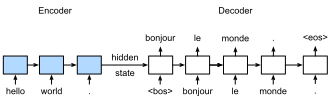

In [1]:
from IPython.display import SVG
SVG(filename= '../img/seq2seq.svg')

Fig 10.14.1: The sequence to sequence model architecture.

The layers in the encoder and the decoder are illustrated in the following figure.

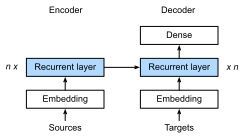

In [2]:
SVG(filename= '../img/seq2seq-details.svg')

In this section we will implement the seq2seq model to train on the machine translation dataset.

In [3]:
import sys
sys.path.insert(0, '..')

import time
import torch
from torch import nn
from torch import optim
import d2l

## Encoder

In the encoder, we use the word embedding layer to obtain a feature index from the word index of the input language and then input it into a multi-level LSTM recurrent unit. The input for the encoder is a batch of sequences, which is 2-D tensor with shape (batch size, sequence length). It outputs both the LSTM outputs, e.g the hidden state, for each time step and the hidden state and memory cell of the last time step.

In [4]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.num_layers=num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
   
    def begin_state(self, batch_size, device):
        return [torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device),
                torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device)]
    def forward(self, X, *args):
        X = self.embedding(X) # X shape: (batch_size, seq_len, embed_size)
        X = X.transpose(0, 1)  # RNN needs first axes to be time
      #  state = self.begin_state(X.shape[1], device=X.device)
        out, state = self.rnn(X)
        # The shape of out is (seq_len, batch_size, num_hiddens).
        # state contains the hidden state and the memory cell
        # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
        return out, state

Next, we will create a mini-batch sequence input with a batch size of 4 and 7 time steps. We assume the number of hidden layers of the LSTM unit is 2 and the number of hidden units is 16. The output shape returned by the encoder after performing forward calculation on the input is (number of time steps, batch size, number of hidden units). The shape of the multi-layer hidden state of the gated recurrent unit in the final time step is (number of hidden layers, batch size, number of hidden units). For the gated recurrent unit, the `state` list contains only one element, which is the hidden state. If long short-term memory is used, the `state` list will also contain another element, which is the memory cell.

In [5]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## Decoder

We directly use the hidden state of the encoder in the final time step as the initial hidden state of the decoder. This requires that the encoder and decoder RNNs have the same numbers of layers and hidden units.

The forward calculation of the decoder is similar to the encoder's. The only difference is we add a dense layer with the hidden size to be the vocabulary size to output the predicted confidence score for each word.

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).transpose(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).transpose(0, 1)
        return out, state

We create an decoder with the same hyper-parameters as the encoder. As can be seen, the output shape is changed to (batch size, the sequence length, vocabulary size).

In [7]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## The Loss Function

For each time step, the decoder outputs a vocabulary size confident score vector to predict words. Similar to language modeling, we can apply softmax to obtain the probabilities and then use cross entropy loss the calculate the loss. But note that we padded the target sentences to make them have the same length. We wound not like to compute the loss on the padding symbols.

To implement the loss function that filters out some entries, we will use an operator called `SequenceMask`. It can specify to mask the first dimension (`axis=0`) or the second one (`axis=1`). If the second one is chosen, given a valid length vector `len` and 2-dim input `X`, this operator sets `X[i, len[i]:] = 0` for all $i$'s.

In [8]:
def SequenceMask(X, X_len,value=0):
    maxlen = X.size(1)
    mask = torch.arange(maxlen)[None, :] < X_len[:, None]    
    X[~mask]=value
    return X

In [9]:
X = torch.tensor([[1,2,3], [4,5,6]])
SequenceMask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

Apply to $n$-dim tensor $X$, it sets `X[i, len[i]:, :, ..., :] = 0`. In addition, we can specify the filling value beyond 0.

In [10]:
X = torch.ones((2,3, 4))
SequenceMask(X, torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Now we can implement the masked version of the softmax cross-entropy loss. Note that each PyTorch loss function allows to specify per-class weights (with a bit of manipulation it can be used for specifying per-sample weights), in default they are 1s. Then we can just use a zero weight for each example we would like to remove. So our customized loss function accepts an additional `valid_length` argument to ignore some failing elements in each sequence.

In [11]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_length shape: (batch_size, )
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len)
        weights = torch.ones_like(label)
        weights = SequenceMask(weights, valid_length).float()
        self.reduction='none'
        output=super(MaskedSoftmaxCELoss, self).forward(pred.transpose(1,2), label)
        return (output*weights).mean(dim=1)

For a sanity check, we create identical three sequences, keep 4 elements for the first sequence, 2 elements for the second sequence, and none for the last one. Then the first example loss should be 2 times larger than the second one, and the last loss should be 0.

In [12]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones((3, 4, 10)), torch.ones((3,4),dtype=torch.long), torch.tensor([4,3,0]))

tensor([2.3026, 1.7269, 0.0000])

## Training

During training, if the target sequence has length $n$, we feed the first $n-1$ tokens into the decoder as inputs, and the last $n-1$ tokens are used as ground truth label.

In [13]:
def train_ch7(model, data_iter, lr, num_epochs, device):  # Saved in d2l
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss = MaskedSoftmaxCELoss()
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:,:-1], Y[:,1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen).sum()
            l.backward()
            with torch.no_grad():
                d2l.grad_clipping_nn(model, 5, device)
            num_tokens = Y_vlen.sum().item()
            optimizer.step()
            l_sum += l.sum().item()
            num_tokens_sum += num_tokens
        if epoch % 50 == 0:
            print("epoch {0:4d},loss {1:.3f}, time {2:.1f} sec".format( 
                  epoch, (l_sum/num_tokens_sum), time.time()-tic))
            tic = time.time()


Next, we create a model instance and set hyper-parameters. Then, we can train the model.

In [14]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_examples, max_len = 64, 1e3, 10
lr, num_epochs, ctx = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(
    batch_size, max_len, num_examples)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)


In [15]:
train_ch7(model, train_iter, lr, num_epochs, ctx)

epoch   50,loss 0.106, time 19.4 sec
epoch  100,loss 0.050, time 30.4 sec
epoch  150,loss 0.032, time 22.2 sec
epoch  200,loss 0.027, time 18.5 sec
epoch  250,loss 0.025, time 17.2 sec
epoch  300,loss 0.025, time 20.1 sec


## Predicting

Here we implement the simplest method, greedy search, to generate an output
sequence.
During predicting, we feed the same "&lt;bos&gt;" token to the decoder as training at time step 0. But the input token for a later time step is the predicted token from the previous time step.



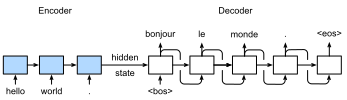

In [16]:
SVG(filename= '../img/seq2seq_predict.svg')

Fig 10.14.2: Sequence to sequence model predicting with greedy search

In [17]:
def translate_ch7(model, src_sentence, src_vocab, tgt_vocab, max_len, device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.tensor(src_tokens, device=device)
    enc_valid_length = torch.tensor([src_len], device=device)
    # use expand_dim to add the batch_size dimension.
    enc_outputs = model.encoder(enc_X.unsqueeze(dim=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.tensor([tgt_vocab.bos], device=device).unsqueeze(dim=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).int().item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

Try several examples:

In [18]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate_ch7(
        model, sentence, src_vocab, tgt_vocab, max_len, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !
